In [155]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import copy

In [156]:
BASE_PATH = ''
device = 'cuda' if torch.cuda.is_available() else 'cpu'

df = pd.read_csv(BASE_PATH)
X = df.iloc[:,:8]
y = df.iloc[:,8:]

X = torch.from_numpy(X.to_numpy()).to(torch.float32)
y = torch.from_numpy(y.to_numpy()).to(torch.float32)
y = torch.reshape(y,(-1,))

df.shape

(768, 9)

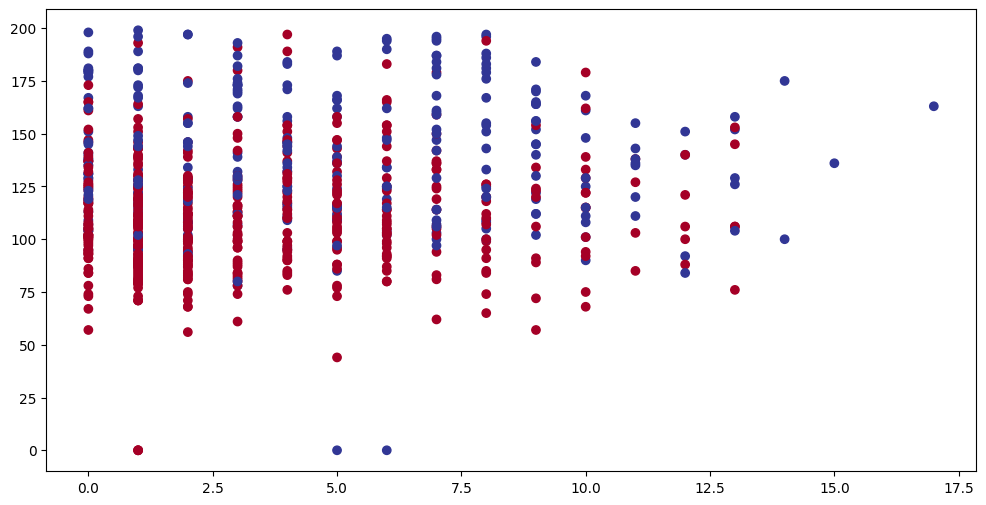

In [157]:
plt.figure(figsize=(12,6))
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdYlBu)

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,shuffle=True)

In [159]:
class DiabeteDataset(Dataset):
  def __init__(self,inputs,outputs,):
    self.inputs = inputs
    self.outputs = outputs

  def __len__(self):
    return len(self.outputs)

  def __getitem__(self,idx):
    input, output = self.inputs[idx], self.outputs[idx]
    return input, output

In [160]:
train_dataloader = DataLoader(DiabeteDataset(X_train,y_train),batch_size=20)
test_dataloader = DataLoader(DiabeteDataset(X_test,y_test))

In [161]:
class DiabeteDetector(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(8,16),
        nn.Linear(16,16),
        nn.Linear(16,8),
        nn.Linear(8,1),
    )

  def forward(self,x):
    return self.layers(x)

In [162]:
torch.manual_seed(42)
model = DiabeteDetector().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(lr = 0.001, params=model.parameters())
epochs = 500

In [163]:
def train_loop(dataloader,model,loss_fn,optimizer):
  global device
  model.train()
  for X, y in dataloader:
    X, y = X.to(device), y.to(device)
    logits = model(X).squeeze(dim=1)
    loss = loss_fn(logits,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def test_loop(dataloader,model,loss_fn):
  global device
  model.eval()
  size = len(dataloader.dataset)
  loss = 0
  corrects = 0

  with torch.no_grad():
    for X,y in dataloader:
      X, y = X.to(device), y.to(device)
      logits = model(X).squeeze(dim=1)
      preds = torch.round(torch.sigmoid(logits))
      loss += loss_fn(logits,y).item()
      corrects += torch.eq(preds,y).item()

  avg_loss = loss / size
  avg_acc = (corrects/size)*100
  print(f'AVG_LOSS: {avg_loss:.5f} -- AVG_ACC {avg_acc:.2f}')
  return avg_loss, avg_acc

In [164]:
losses = []
accs = []
best_acc = 0
best_weights = None

for epoch in range(epochs):
  print(f'EPOCH {epoch+1}')
  train_loop(train_dataloader,model,loss_fn,optimizer)
  loss, acc = test_loop(test_dataloader,model,loss_fn)
  losses.append(loss)
  accs.append(acc)
  if acc > best_acc:
    best_acc = acc
    best_weights = copy.deepcopy(model.state_dict())

print('DONE!')
print(f'BEST ACC: {best_acc}')
response = input('Do you want to save the model: [y/n]').upper()
if response == 'Y':
  model.load_state_dict(best_weights)
  torch.save(model,'DiabeteDetector.pth')

EPOCH 1
AVG_LOSS: 0.72108 -- AVG_ACC 57.79
EPOCH 2
AVG_LOSS: 0.65615 -- AVG_ACC 66.88
EPOCH 3
AVG_LOSS: 0.65710 -- AVG_ACC 65.58
EPOCH 4
AVG_LOSS: 0.64403 -- AVG_ACC 67.53
EPOCH 5
AVG_LOSS: 0.64306 -- AVG_ACC 67.53
EPOCH 6
AVG_LOSS: 0.64047 -- AVG_ACC 66.88
EPOCH 7
AVG_LOSS: 0.63837 -- AVG_ACC 68.18
EPOCH 8
AVG_LOSS: 0.63658 -- AVG_ACC 68.83
EPOCH 9
AVG_LOSS: 0.63498 -- AVG_ACC 68.18
EPOCH 10
AVG_LOSS: 0.63350 -- AVG_ACC 68.18
EPOCH 11
AVG_LOSS: 0.63209 -- AVG_ACC 68.18
EPOCH 12
AVG_LOSS: 0.63073 -- AVG_ACC 68.83
EPOCH 13
AVG_LOSS: 0.62938 -- AVG_ACC 68.18
EPOCH 14
AVG_LOSS: 0.62805 -- AVG_ACC 68.83
EPOCH 15
AVG_LOSS: 0.62672 -- AVG_ACC 68.18
EPOCH 16
AVG_LOSS: 0.62538 -- AVG_ACC 68.18
EPOCH 17
AVG_LOSS: 0.62403 -- AVG_ACC 68.18
EPOCH 18
AVG_LOSS: 0.62268 -- AVG_ACC 68.18
EPOCH 19
AVG_LOSS: 0.62132 -- AVG_ACC 67.53
EPOCH 20
AVG_LOSS: 0.61995 -- AVG_ACC 66.88
EPOCH 21
AVG_LOSS: 0.61858 -- AVG_ACC 66.88
EPOCH 22
AVG_LOSS: 0.61720 -- AVG_ACC 66.88
EPOCH 23
AVG_LOSS: 0.61581 -- AVG_ACC 66.

[Text(0.5, 0, 'EPOCH'), Text(0, 0.5, 'ACCURACY')]

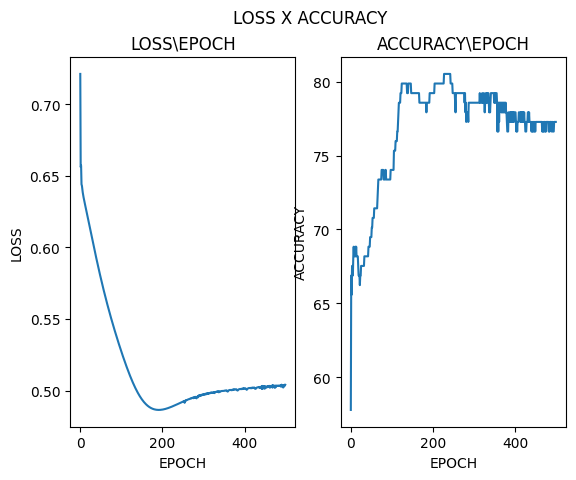

In [165]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('LOSS X ACCURACY')
ax1.plot(losses)
ax1.set_title('LOSS\EPOCH')
ax1.set(xlabel='EPOCH',ylabel='LOSS')
ax2.plot(accs)
ax2.set_title('ACCURACY\EPOCH')
ax2.set(xlabel='EPOCH',ylabel='ACCURACY')